In [13]:
import os
import numpy as np
import torch

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# Set paths for clean and contaminated EEG data
clean_dir = "/home/tulgaa/Desktop/eeg_last/eeg_last/Extracted_Bands/Clean"
contaminated_dir = "/home/tulgaa/Desktop/eeg_last/eeg_last/Extracted_Bands/Contaminated"

# Define EEG frequency bands
bands = ["Delta_band", "Theta_band", "Alpha_band", "Beta_band", "Gamma_band", "High_Frequencies_band"]

print(f"✅ Clean EEG Directory: {clean_dir}")
print(f"✅ Contaminated EEG Directory: {contaminated_dir}")
print(f"✅ EEG Bands: {bands}")


✅ Using device: cuda
✅ Clean EEG Directory: /home/tulgaa/Desktop/eeg_last/eeg_last/Extracted_Bands/Clean
✅ Contaminated EEG Directory: /home/tulgaa/Desktop/eeg_last/eeg_last/Extracted_Bands/Contaminated
✅ EEG Bands: ['Delta_band', 'Theta_band', 'Alpha_band', 'Beta_band', 'Gamma_band', 'High_Frequencies_band']


In [14]:
from sklearn.model_selection import train_test_split

def load_and_split_data(band_name):
    """
    Loads EEG data for a specific frequency band, splits into train and test sets based on SNR levels.
    """
    print(f"\n📌 Loading and Splitting Data for {band_name}...")

    # Load clean EEG data
    clean_band_path = os.path.join(clean_dir, f"{band_name}.npy")
    clean_band = np.load(clean_band_path)

    # Load contaminated EEG data across all SNR levels
    contaminated_band = []
    snr_labels = []

    for snr_folder in sorted(os.listdir(contaminated_dir)):  # Iterate through SNR folders
        contaminated_band_path = os.path.join(contaminated_dir, snr_folder, f"{band_name}.npy")
        contaminated_data = np.load(contaminated_band_path)

        contaminated_band.append(contaminated_data)
        snr_labels.extend([snr_folder] * len(contaminated_data))  # Track SNR levels

    # Convert lists to numpy arrays
    contaminated_band = np.concatenate(contaminated_band, axis=0)
    # Convert string labels ("SNR_-7") to integers (-7)
    
    snr_labels = np.array([int(snr.replace("SNR_", "")) for snr in snr_labels])


    # Ensure clean_band is correctly repeated to match contaminated EEG samples
    clean_band_repeated = np.tile(clean_band, (len(contaminated_band) // len(clean_band) + 1, 1))[:len(contaminated_band)]

    # Stratified Train-Test Split
    train_clean, test_clean, train_contaminated, test_contaminated, snr_labels_train, snr_labels_test = train_test_split(
        clean_band_repeated, contaminated_band, snr_labels, test_size=0.2, stratify=snr_labels, random_state=42
    )

    # Inspect data shapes
    print(f"✅ {band_name} Train Clean Shape: {train_clean.shape}, Test Clean Shape: {test_clean.shape}")
    print(f"✅ {band_name} Train Contaminated Shape: {train_contaminated.shape}, Test Contaminated Shape: {test_contaminated.shape}")
    print(f"✅ {band_name} SNR Labels Train: {np.unique(snr_labels_train)}, Test: {np.unique(snr_labels_test)}")

    return train_clean, train_contaminated, test_clean, test_contaminated, snr_labels_train, snr_labels_test

# Load and split data for each EEG band
train_data = {}
test_data = {}

for band in bands:
    train_clean, train_contaminated, test_clean, test_contaminated, snr_labels_train, snr_labels_test = load_and_split_data(band)
    train_data[band] = (train_clean, train_contaminated)
    test_data[band] = (test_clean, test_contaminated, snr_labels_test)

print("\n✅ All EEG bands successfully loaded and split!")



📌 Loading and Splitting Data for Delta_band...
✅ Delta_band Train Clean Shape: (27200, 512), Test Clean Shape: (6800, 512)
✅ Delta_band Train Contaminated Shape: (27200, 512), Test Contaminated Shape: (6800, 512)
✅ Delta_band SNR Labels Train: [-7 -6 -5 -4 -3 -2 -1  0  1  2], Test: [-7 -6 -5 -4 -3 -2 -1  0  1  2]

📌 Loading and Splitting Data for Theta_band...
✅ Theta_band Train Clean Shape: (27200, 512), Test Clean Shape: (6800, 512)
✅ Theta_band Train Contaminated Shape: (27200, 512), Test Contaminated Shape: (6800, 512)
✅ Theta_band SNR Labels Train: [-7 -6 -5 -4 -3 -2 -1  0  1  2], Test: [-7 -6 -5 -4 -3 -2 -1  0  1  2]

📌 Loading and Splitting Data for Alpha_band...
✅ Alpha_band Train Clean Shape: (27200, 512), Test Clean Shape: (6800, 512)
✅ Alpha_band Train Contaminated Shape: (27200, 512), Test Contaminated Shape: (6800, 512)
✅ Alpha_band SNR Labels Train: [-7 -6 -5 -4 -3 -2 -1  0  1  2], Test: [-7 -6 -5 -4 -3 -2 -1  0  1  2]

📌 Loading and Splitting Data for Beta_band...
✅ Bet

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader

# 🔧 Custom Dataset class for 6-band denoising
class EEGDenoiseDataset(torch.utils.data.Dataset):
    def __init__(self, train_data_dict):
        self.bands = list(train_data_dict.keys())
        self.inputs = []
        self.targets = []

        # Stack each band's data into [6, 1024] per sample
        for i in range(len(train_data_dict[self.bands[0]][0])):  # same length for all bands
            input_stack = []
            target_stack = []

            for band in self.bands:
                clean, contaminated = train_data_dict[band]
                input_stack.append(contaminated[i])  # (1024,)
                target_stack.append(clean[i])        # (1024,)

            # Stack to shape (6, 1024)
            self.inputs.append(np.stack(input_stack, axis=0))
            self.targets.append(np.stack(target_stack, axis=0))

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        
        # Inside __getitem__ of EEGDenoiseDataset
        x = torch.tensor(self.inputs[idx], dtype=torch.float32)
        y = torch.tensor(self.targets[idx], dtype=torch.float32)

# Sum across bands to match the model's output
        y = y.sum(dim=0)

        return x.to(device), y.to(device)
    

# Create dataset and loaders
train_dataset = EEGDenoiseDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print("✅ EEGDenoiseDataset and DataLoader ready.")
print(f"🧾 Total training samples: {len(train_dataset)}")



✅ EEGDenoiseDataset and DataLoader ready.
🧾 Total training samples: 27200


In [18]:
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1024):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        pe = pe.unsqueeze(0).transpose(1, 2)  # Shape: [1, d_model, max_len]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [batch_size, channels, sequence_length]
        x = x + self.pe[:, :, :x.size(2)]
        return x


class EEGCleanFormer(nn.Module):
    def __init__(self, seq_len=1024, input_channels=6, model_dim=64, num_heads=4, num_layers=2):
        super(EEGCleanFormer, self).__init__()

        # 1️⃣ CNN Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(input_channels, model_dim, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.BatchNorm1d(model_dim),
            nn.Conv1d(model_dim, model_dim, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(model_dim),
        )

        # 2️⃣ Positional Encoding
        self.pos_encoding = PositionalEncoding(d_model=model_dim, max_len=seq_len)

        # 3️⃣ Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # 4️⃣ Reconstruction Head
        self.decoder = nn.Sequential(
            nn.Conv1d(model_dim, model_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(model_dim, 1, kernel_size=1)
        )

    def forward(self, x):
        # x shape: [batch_size, 6, 1024]
        x = self.encoder(x)  # → [B, model_dim, 1024]
        x = self.pos_encoding(x)  # Add PE
        x = x.permute(0, 2, 1)  # [B, 1024, model_dim] for Transformer
        x = self.transformer(x)  # → [B, 1024, model_dim]
        x = x.permute(0, 2, 1)  # → [B, model_dim, 1024]
        x = self.decoder(x)     # → [B, 1, 1024]
        return x.squeeze(1)     # → [B, 1024]
    
# Instantiate model
model = EEGCleanFormer().to(device)
print("✅ EEGCleanFormer initialized.")


✅ EEGCleanFormer initialized.


In [19]:
import torch.optim as optim
from tqdm import tqdm

# 🔧 Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 🔂 Early Stopping
class EarlyStopping:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True

early_stopping = EarlyStopping()

# 🔁 Training Loop
num_epochs = 200
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f"📉 Epoch {epoch+1}: Train Loss = {avg_loss:.6f}")

    early_stopping(avg_loss)
    if early_stopping.stop:
        print("⛔ Early stopping triggered.")
        break

print("✅ Training complete.")


Epoch 1/200: 100%|██████████| 850/850 [00:17<00:00, 47.31it/s]


📉 Epoch 1: Train Loss = 17598.170432


Epoch 2/200: 100%|██████████| 850/850 [00:17<00:00, 48.01it/s]


📉 Epoch 2: Train Loss = 11264.521959


Epoch 3/200: 100%|██████████| 850/850 [00:17<00:00, 47.85it/s]


📉 Epoch 3: Train Loss = 10542.256884


Epoch 4/200: 100%|██████████| 850/850 [00:17<00:00, 47.50it/s]


📉 Epoch 4: Train Loss = 9991.872457


Epoch 5/200: 100%|██████████| 850/850 [00:17<00:00, 47.24it/s]


📉 Epoch 5: Train Loss = 9520.304531


Epoch 6/200: 100%|██████████| 850/850 [00:17<00:00, 47.44it/s]


📉 Epoch 6: Train Loss = 9186.471772


Epoch 7/200: 100%|██████████| 850/850 [00:18<00:00, 47.15it/s]


📉 Epoch 7: Train Loss = 8752.647071


Epoch 8/200: 100%|██████████| 850/850 [00:18<00:00, 46.59it/s]


📉 Epoch 8: Train Loss = 8346.248045


Epoch 9/200: 100%|██████████| 850/850 [00:18<00:00, 46.97it/s]


📉 Epoch 9: Train Loss = 7944.964771


Epoch 10/200: 100%|██████████| 850/850 [00:18<00:00, 47.02it/s]


📉 Epoch 10: Train Loss = 7512.561976


Epoch 11/200: 100%|██████████| 850/850 [00:18<00:00, 47.12it/s]


📉 Epoch 11: Train Loss = 7140.381292


Epoch 12/200: 100%|██████████| 850/850 [00:18<00:00, 46.70it/s]


📉 Epoch 12: Train Loss = 6736.229132


Epoch 13/200: 100%|██████████| 850/850 [00:18<00:00, 46.68it/s]


📉 Epoch 13: Train Loss = 6446.079074


Epoch 14/200: 100%|██████████| 850/850 [00:18<00:00, 46.68it/s]


📉 Epoch 14: Train Loss = 6114.310078


Epoch 15/200: 100%|██████████| 850/850 [00:18<00:00, 47.16it/s]


📉 Epoch 15: Train Loss = 5795.228041


Epoch 16/200: 100%|██████████| 850/850 [00:18<00:00, 47.05it/s]


📉 Epoch 16: Train Loss = 5567.856440


Epoch 17/200: 100%|██████████| 850/850 [00:18<00:00, 47.10it/s]


📉 Epoch 17: Train Loss = 5297.360921


Epoch 18/200: 100%|██████████| 850/850 [00:18<00:00, 47.07it/s]


📉 Epoch 18: Train Loss = 5115.010816


Epoch 19/200: 100%|██████████| 850/850 [00:18<00:00, 46.80it/s]


📉 Epoch 19: Train Loss = 4938.066349


Epoch 20/200: 100%|██████████| 850/850 [00:18<00:00, 46.91it/s]


📉 Epoch 20: Train Loss = 4726.289755


Epoch 21/200: 100%|██████████| 850/850 [00:18<00:00, 46.62it/s]


📉 Epoch 21: Train Loss = 4579.271356


Epoch 22/200: 100%|██████████| 850/850 [00:18<00:00, 46.91it/s]


📉 Epoch 22: Train Loss = 4401.395584


Epoch 23/200: 100%|██████████| 850/850 [00:18<00:00, 46.89it/s]


📉 Epoch 23: Train Loss = 4307.968262


Epoch 24/200: 100%|██████████| 850/850 [00:18<00:00, 46.64it/s]


📉 Epoch 24: Train Loss = 4174.136655


Epoch 25/200: 100%|██████████| 850/850 [00:18<00:00, 46.83it/s]


📉 Epoch 25: Train Loss = 4051.207500


Epoch 26/200: 100%|██████████| 850/850 [00:18<00:00, 46.70it/s]


📉 Epoch 26: Train Loss = 3970.849687


Epoch 27/200: 100%|██████████| 850/850 [00:18<00:00, 46.64it/s]


📉 Epoch 27: Train Loss = 3857.460506


Epoch 28/200: 100%|██████████| 850/850 [00:18<00:00, 46.63it/s]


📉 Epoch 28: Train Loss = 3771.866041


Epoch 29/200: 100%|██████████| 850/850 [00:18<00:00, 46.80it/s]


📉 Epoch 29: Train Loss = 3722.931459


Epoch 30/200: 100%|██████████| 850/850 [00:18<00:00, 46.79it/s]


📉 Epoch 30: Train Loss = 3643.369561


Epoch 31/200: 100%|██████████| 850/850 [00:18<00:00, 46.60it/s]


📉 Epoch 31: Train Loss = 3546.369515


Epoch 32/200: 100%|██████████| 850/850 [00:18<00:00, 46.50it/s]


📉 Epoch 32: Train Loss = 3502.748955


Epoch 33/200: 100%|██████████| 850/850 [00:18<00:00, 46.35it/s]


📉 Epoch 33: Train Loss = 3449.845206


Epoch 34/200: 100%|██████████| 850/850 [00:18<00:00, 46.23it/s]


📉 Epoch 34: Train Loss = 3374.918528


Epoch 35/200: 100%|██████████| 850/850 [00:18<00:00, 46.84it/s]


📉 Epoch 35: Train Loss = 3305.362175


Epoch 36/200: 100%|██████████| 850/850 [00:18<00:00, 46.66it/s]


📉 Epoch 36: Train Loss = 3266.458601


Epoch 37/200: 100%|██████████| 850/850 [00:18<00:00, 46.91it/s]


📉 Epoch 37: Train Loss = 3276.201204


Epoch 38/200: 100%|██████████| 850/850 [00:18<00:00, 46.96it/s]


📉 Epoch 38: Train Loss = 3198.938337


Epoch 39/200: 100%|██████████| 850/850 [00:18<00:00, 46.87it/s]


📉 Epoch 39: Train Loss = 3150.454679


Epoch 40/200: 100%|██████████| 850/850 [00:18<00:00, 46.62it/s]


📉 Epoch 40: Train Loss = 3115.860939


Epoch 41/200: 100%|██████████| 850/850 [00:18<00:00, 46.59it/s]


📉 Epoch 41: Train Loss = 3083.402456


Epoch 42/200: 100%|██████████| 850/850 [00:18<00:00, 46.34it/s]


📉 Epoch 42: Train Loss = 3034.159063


Epoch 43/200: 100%|██████████| 850/850 [00:18<00:00, 46.41it/s]


📉 Epoch 43: Train Loss = 2987.200308


Epoch 44/200: 100%|██████████| 850/850 [00:18<00:00, 46.45it/s]


📉 Epoch 44: Train Loss = 2958.300795


Epoch 45/200: 100%|██████████| 850/850 [00:18<00:00, 46.45it/s]


📉 Epoch 45: Train Loss = 2929.332762


Epoch 46/200: 100%|██████████| 850/850 [00:18<00:00, 46.90it/s]


📉 Epoch 46: Train Loss = 2902.027806


Epoch 47/200: 100%|██████████| 850/850 [00:18<00:00, 46.65it/s]


📉 Epoch 47: Train Loss = 2889.380044


Epoch 48/200: 100%|██████████| 850/850 [00:18<00:00, 46.51it/s]


📉 Epoch 48: Train Loss = 2870.712303


Epoch 49/200: 100%|██████████| 850/850 [00:18<00:00, 46.80it/s]


📉 Epoch 49: Train Loss = 2826.475502


Epoch 50/200: 100%|██████████| 850/850 [00:18<00:00, 46.88it/s]


📉 Epoch 50: Train Loss = 2798.331869


Epoch 51/200: 100%|██████████| 850/850 [00:18<00:00, 46.50it/s]


📉 Epoch 51: Train Loss = 2773.613019


Epoch 52/200: 100%|██████████| 850/850 [00:18<00:00, 46.47it/s]


📉 Epoch 52: Train Loss = 2732.331587


Epoch 53/200: 100%|██████████| 850/850 [00:18<00:00, 47.05it/s]


📉 Epoch 53: Train Loss = 2735.323396


Epoch 54/200: 100%|██████████| 850/850 [00:18<00:00, 46.63it/s]


📉 Epoch 54: Train Loss = 2716.156654


Epoch 55/200: 100%|██████████| 850/850 [00:18<00:00, 46.56it/s]


📉 Epoch 55: Train Loss = 2692.508747


Epoch 56/200: 100%|██████████| 850/850 [00:18<00:00, 46.55it/s]


📉 Epoch 56: Train Loss = 2675.845816


Epoch 57/200: 100%|██████████| 850/850 [00:18<00:00, 46.36it/s]


📉 Epoch 57: Train Loss = 2635.372140


Epoch 58/200: 100%|██████████| 850/850 [00:18<00:00, 46.53it/s]


📉 Epoch 58: Train Loss = 2628.251694


Epoch 59/200: 100%|██████████| 850/850 [00:18<00:00, 46.77it/s]


📉 Epoch 59: Train Loss = 2596.372771


Epoch 60/200: 100%|██████████| 850/850 [00:18<00:00, 46.70it/s]


📉 Epoch 60: Train Loss = 2609.519706


Epoch 61/200: 100%|██████████| 850/850 [00:18<00:00, 46.49it/s]


📉 Epoch 61: Train Loss = 2584.219390


Epoch 62/200: 100%|██████████| 850/850 [00:18<00:00, 46.71it/s]


📉 Epoch 62: Train Loss = 2586.833151


Epoch 63/200: 100%|██████████| 850/850 [00:18<00:00, 46.88it/s]


📉 Epoch 63: Train Loss = 2530.768371


Epoch 64/200: 100%|██████████| 850/850 [00:18<00:00, 46.90it/s]


📉 Epoch 64: Train Loss = 2527.984699


Epoch 65/200: 100%|██████████| 850/850 [00:18<00:00, 46.85it/s]


📉 Epoch 65: Train Loss = 2534.627955


Epoch 66/200: 100%|██████████| 850/850 [00:18<00:00, 46.74it/s]


📉 Epoch 66: Train Loss = 2492.434964


Epoch 67/200: 100%|██████████| 850/850 [00:18<00:00, 46.72it/s]


📉 Epoch 67: Train Loss = 2505.161100


Epoch 68/200: 100%|██████████| 850/850 [00:18<00:00, 46.57it/s]


📉 Epoch 68: Train Loss = 2488.996824


Epoch 69/200: 100%|██████████| 850/850 [00:18<00:00, 47.06it/s]


📉 Epoch 69: Train Loss = 2481.862868


Epoch 70/200: 100%|██████████| 850/850 [00:18<00:00, 47.11it/s]


📉 Epoch 70: Train Loss = 2436.808735


Epoch 71/200: 100%|██████████| 850/850 [00:18<00:00, 46.81it/s]


📉 Epoch 71: Train Loss = 2440.355034


Epoch 72/200: 100%|██████████| 850/850 [00:18<00:00, 46.09it/s]


📉 Epoch 72: Train Loss = 2431.216130


Epoch 73/200: 100%|██████████| 850/850 [00:18<00:00, 46.70it/s]


📉 Epoch 73: Train Loss = 2412.781758


Epoch 74/200: 100%|██████████| 850/850 [00:18<00:00, 46.66it/s]


📉 Epoch 74: Train Loss = 2403.246374


Epoch 75/200: 100%|██████████| 850/850 [00:18<00:00, 47.08it/s]


📉 Epoch 75: Train Loss = 2384.103728


Epoch 76/200: 100%|██████████| 850/850 [00:18<00:00, 46.77it/s]


📉 Epoch 76: Train Loss = 2386.903978


Epoch 77/200: 100%|██████████| 850/850 [00:18<00:00, 46.59it/s]


📉 Epoch 77: Train Loss = 2369.577095


Epoch 78/200: 100%|██████████| 850/850 [00:18<00:00, 46.83it/s]


📉 Epoch 78: Train Loss = 2372.115700


Epoch 79/200: 100%|██████████| 850/850 [00:18<00:00, 46.78it/s]


📉 Epoch 79: Train Loss = 2368.064176


Epoch 80/200: 100%|██████████| 850/850 [00:18<00:00, 46.70it/s]


📉 Epoch 80: Train Loss = 2334.988164


Epoch 81/200: 100%|██████████| 850/850 [00:18<00:00, 46.90it/s]


📉 Epoch 81: Train Loss = 2329.044189


Epoch 82/200: 100%|██████████| 850/850 [00:18<00:00, 46.43it/s]


📉 Epoch 82: Train Loss = 2314.383098


Epoch 83/200: 100%|██████████| 850/850 [00:18<00:00, 46.25it/s]


📉 Epoch 83: Train Loss = 2318.010369


Epoch 84/200: 100%|██████████| 850/850 [00:18<00:00, 46.36it/s]


📉 Epoch 84: Train Loss = 2322.763393


Epoch 85/200: 100%|██████████| 850/850 [00:18<00:00, 46.88it/s]


📉 Epoch 85: Train Loss = 2310.277314


Epoch 86/200: 100%|██████████| 850/850 [00:18<00:00, 46.64it/s]


📉 Epoch 86: Train Loss = 2284.176849


Epoch 87/200: 100%|██████████| 850/850 [00:18<00:00, 46.72it/s]


📉 Epoch 87: Train Loss = 2278.040425


Epoch 88/200: 100%|██████████| 850/850 [00:18<00:00, 46.34it/s]


📉 Epoch 88: Train Loss = 2271.447555


Epoch 89/200: 100%|██████████| 850/850 [00:18<00:00, 46.57it/s]


📉 Epoch 89: Train Loss = 2276.443415


Epoch 90/200: 100%|██████████| 850/850 [00:18<00:00, 46.17it/s]


📉 Epoch 90: Train Loss = 2252.916934


Epoch 91/200: 100%|██████████| 850/850 [00:18<00:00, 46.80it/s]


📉 Epoch 91: Train Loss = 2269.313940


Epoch 92/200: 100%|██████████| 850/850 [00:18<00:00, 46.92it/s]


📉 Epoch 92: Train Loss = 2256.788710


Epoch 93/200: 100%|██████████| 850/850 [00:18<00:00, 46.77it/s]


📉 Epoch 93: Train Loss = 2240.208707


Epoch 94/200: 100%|██████████| 850/850 [00:18<00:00, 47.03it/s]


📉 Epoch 94: Train Loss = 2219.656859


Epoch 95/200: 100%|██████████| 850/850 [00:18<00:00, 47.10it/s]


📉 Epoch 95: Train Loss = 2229.099197


Epoch 96/200: 100%|██████████| 850/850 [00:18<00:00, 46.97it/s]


📉 Epoch 96: Train Loss = 2235.901992


Epoch 97/200: 100%|██████████| 850/850 [00:18<00:00, 46.82it/s]


📉 Epoch 97: Train Loss = 2194.863719


Epoch 98/200: 100%|██████████| 850/850 [00:18<00:00, 46.45it/s]


📉 Epoch 98: Train Loss = 2200.113027


Epoch 99/200: 100%|██████████| 850/850 [00:18<00:00, 46.29it/s]


📉 Epoch 99: Train Loss = 2192.389106


Epoch 100/200: 100%|██████████| 850/850 [00:18<00:00, 46.79it/s]


📉 Epoch 100: Train Loss = 2179.537258


Epoch 101/200: 100%|██████████| 850/850 [00:18<00:00, 46.82it/s]


📉 Epoch 101: Train Loss = 2188.812450


Epoch 102/200: 100%|██████████| 850/850 [00:18<00:00, 46.77it/s]


📉 Epoch 102: Train Loss = 2178.903334


Epoch 103/200: 100%|██████████| 850/850 [00:18<00:00, 46.68it/s]


📉 Epoch 103: Train Loss = 2149.564899


Epoch 104/200: 100%|██████████| 850/850 [00:18<00:00, 46.74it/s]


📉 Epoch 104: Train Loss = 2163.928804


Epoch 105/200: 100%|██████████| 850/850 [00:18<00:00, 46.66it/s]


📉 Epoch 105: Train Loss = 2155.285768


Epoch 106/200: 100%|██████████| 850/850 [00:18<00:00, 46.10it/s]


📉 Epoch 106: Train Loss = 2150.221165


Epoch 107/200: 100%|██████████| 850/850 [00:18<00:00, 46.51it/s]


📉 Epoch 107: Train Loss = 2135.875780


Epoch 108/200: 100%|██████████| 850/850 [00:18<00:00, 46.64it/s]


📉 Epoch 108: Train Loss = 2126.925347


Epoch 109/200: 100%|██████████| 850/850 [00:18<00:00, 46.37it/s]


📉 Epoch 109: Train Loss = 2140.675957


Epoch 110/200: 100%|██████████| 850/850 [00:18<00:00, 46.90it/s]


📉 Epoch 110: Train Loss = 2128.168698


Epoch 111/200: 100%|██████████| 850/850 [00:18<00:00, 46.87it/s]


📉 Epoch 111: Train Loss = 2118.804025


Epoch 112/200: 100%|██████████| 850/850 [00:18<00:00, 46.99it/s]


📉 Epoch 112: Train Loss = 2108.118128


Epoch 113/200: 100%|██████████| 850/850 [00:18<00:00, 46.67it/s]


📉 Epoch 113: Train Loss = 2125.353663


Epoch 114/200: 100%|██████████| 850/850 [00:18<00:00, 46.83it/s]


📉 Epoch 114: Train Loss = 2097.894261


Epoch 115/200: 100%|██████████| 850/850 [00:18<00:00, 46.82it/s]


📉 Epoch 115: Train Loss = 2087.441591


Epoch 116/200: 100%|██████████| 850/850 [00:18<00:00, 46.29it/s]


📉 Epoch 116: Train Loss = 2103.496033


Epoch 117/200: 100%|██████████| 850/850 [00:18<00:00, 46.76it/s]


📉 Epoch 117: Train Loss = 2095.031082


Epoch 118/200: 100%|██████████| 850/850 [00:18<00:00, 46.93it/s]


📉 Epoch 118: Train Loss = 2098.017357


Epoch 119/200: 100%|██████████| 850/850 [00:18<00:00, 46.67it/s]


📉 Epoch 119: Train Loss = 2065.934298


Epoch 120/200: 100%|██████████| 850/850 [00:18<00:00, 46.44it/s]


📉 Epoch 120: Train Loss = 2087.792911


Epoch 121/200: 100%|██████████| 850/850 [00:18<00:00, 46.40it/s]


📉 Epoch 121: Train Loss = 2056.423614


Epoch 122/200: 100%|██████████| 850/850 [00:18<00:00, 46.36it/s]


📉 Epoch 122: Train Loss = 2051.869341


Epoch 123/200: 100%|██████████| 850/850 [00:18<00:00, 46.52it/s]


📉 Epoch 123: Train Loss = 2060.215181


Epoch 124/200: 100%|██████████| 850/850 [00:18<00:00, 46.53it/s]


📉 Epoch 124: Train Loss = 2058.338777


Epoch 125/200: 100%|██████████| 850/850 [00:18<00:00, 46.99it/s]


📉 Epoch 125: Train Loss = 2059.232743


Epoch 126/200: 100%|██████████| 850/850 [00:18<00:00, 46.62it/s]


📉 Epoch 126: Train Loss = 2051.580442


Epoch 127/200: 100%|██████████| 850/850 [00:18<00:00, 46.57it/s]


📉 Epoch 127: Train Loss = 2047.995008


Epoch 128/200: 100%|██████████| 850/850 [00:18<00:00, 46.35it/s]


📉 Epoch 128: Train Loss = 2044.358424


Epoch 129/200: 100%|██████████| 850/850 [00:18<00:00, 46.38it/s]


📉 Epoch 129: Train Loss = 2032.291925


Epoch 130/200: 100%|██████████| 850/850 [00:18<00:00, 46.92it/s]


📉 Epoch 130: Train Loss = 2032.765000


Epoch 131/200: 100%|██████████| 850/850 [00:18<00:00, 46.54it/s]


📉 Epoch 131: Train Loss = 2037.515547


Epoch 132/200: 100%|██████████| 850/850 [00:18<00:00, 46.92it/s]


📉 Epoch 132: Train Loss = 2014.385837


Epoch 133/200: 100%|██████████| 850/850 [00:18<00:00, 46.71it/s]


📉 Epoch 133: Train Loss = 2009.319485


Epoch 134/200: 100%|██████████| 850/850 [00:18<00:00, 46.86it/s]


📉 Epoch 134: Train Loss = 2003.151361


Epoch 135/200: 100%|██████████| 850/850 [00:18<00:00, 46.78it/s]


📉 Epoch 135: Train Loss = 2032.830155


Epoch 136/200: 100%|██████████| 850/850 [00:18<00:00, 46.76it/s]


📉 Epoch 136: Train Loss = 2004.978789


Epoch 137/200: 100%|██████████| 850/850 [00:18<00:00, 46.70it/s]


📉 Epoch 137: Train Loss = 2007.400277


Epoch 138/200: 100%|██████████| 850/850 [00:18<00:00, 46.53it/s]


📉 Epoch 138: Train Loss = 2009.523402


Epoch 139/200: 100%|██████████| 850/850 [00:18<00:00, 46.93it/s]


📉 Epoch 139: Train Loss = 2008.415066


Epoch 140/200: 100%|██████████| 850/850 [00:18<00:00, 46.92it/s]


📉 Epoch 140: Train Loss = 2003.160407


Epoch 141/200: 100%|██████████| 850/850 [00:18<00:00, 46.48it/s]


📉 Epoch 141: Train Loss = 1979.604696


Epoch 142/200: 100%|██████████| 850/850 [00:18<00:00, 46.70it/s]


📉 Epoch 142: Train Loss = 1996.361172


Epoch 143/200: 100%|██████████| 850/850 [00:18<00:00, 46.78it/s]


📉 Epoch 143: Train Loss = 1988.289168


Epoch 144/200: 100%|██████████| 850/850 [00:18<00:00, 46.67it/s]


📉 Epoch 144: Train Loss = 1978.684879


Epoch 145/200: 100%|██████████| 850/850 [00:18<00:00, 46.94it/s]


📉 Epoch 145: Train Loss = 1977.640140


Epoch 146/200: 100%|██████████| 850/850 [00:18<00:00, 46.33it/s]


📉 Epoch 146: Train Loss = 1973.220910


Epoch 147/200: 100%|██████████| 850/850 [00:18<00:00, 46.46it/s]


📉 Epoch 147: Train Loss = 1981.045539


Epoch 148/200: 100%|██████████| 850/850 [00:18<00:00, 46.54it/s]


📉 Epoch 148: Train Loss = 1961.270331


Epoch 149/200: 100%|██████████| 850/850 [00:18<00:00, 46.79it/s]


📉 Epoch 149: Train Loss = 1964.507575


Epoch 150/200: 100%|██████████| 850/850 [00:18<00:00, 46.19it/s]


📉 Epoch 150: Train Loss = 1955.714395


Epoch 151/200: 100%|██████████| 850/850 [00:18<00:00, 45.87it/s]


📉 Epoch 151: Train Loss = 1947.914967


Epoch 152/200: 100%|██████████| 850/850 [00:18<00:00, 46.70it/s]


📉 Epoch 152: Train Loss = 1955.997942


Epoch 153/200: 100%|██████████| 850/850 [00:18<00:00, 46.77it/s]


📉 Epoch 153: Train Loss = 1938.956347


Epoch 154/200: 100%|██████████| 850/850 [00:18<00:00, 46.77it/s]


📉 Epoch 154: Train Loss = 1958.380565


Epoch 155/200: 100%|██████████| 850/850 [00:18<00:00, 46.92it/s]


📉 Epoch 155: Train Loss = 1946.407327


Epoch 156/200: 100%|██████████| 850/850 [00:18<00:00, 46.52it/s]


📉 Epoch 156: Train Loss = 1940.315247


Epoch 157/200: 100%|██████████| 850/850 [00:18<00:00, 47.03it/s]


📉 Epoch 157: Train Loss = 1929.955080


Epoch 158/200: 100%|██████████| 850/850 [00:18<00:00, 46.75it/s]


📉 Epoch 158: Train Loss = 1931.532573


Epoch 159/200: 100%|██████████| 850/850 [00:18<00:00, 46.66it/s]


📉 Epoch 159: Train Loss = 1934.023525


Epoch 160/200: 100%|██████████| 850/850 [00:18<00:00, 46.15it/s]


📉 Epoch 160: Train Loss = 1939.705358


Epoch 161/200: 100%|██████████| 850/850 [00:18<00:00, 46.55it/s]


📉 Epoch 161: Train Loss = 1921.229519


Epoch 162/200: 100%|██████████| 850/850 [00:18<00:00, 46.54it/s]


📉 Epoch 162: Train Loss = 1910.496755


Epoch 163/200: 100%|██████████| 850/850 [00:18<00:00, 46.86it/s]


📉 Epoch 163: Train Loss = 1926.880714


Epoch 164/200: 100%|██████████| 850/850 [00:18<00:00, 46.92it/s]


📉 Epoch 164: Train Loss = 1916.899892


Epoch 165/200: 100%|██████████| 850/850 [00:18<00:00, 46.87it/s]


📉 Epoch 165: Train Loss = 1911.932369


Epoch 166/200: 100%|██████████| 850/850 [00:18<00:00, 46.66it/s]


📉 Epoch 166: Train Loss = 1901.856301


Epoch 167/200: 100%|██████████| 850/850 [00:18<00:00, 46.95it/s]


📉 Epoch 167: Train Loss = 1912.672585


Epoch 168/200: 100%|██████████| 850/850 [00:18<00:00, 46.82it/s]


📉 Epoch 168: Train Loss = 1907.422424


Epoch 169/200: 100%|██████████| 850/850 [00:18<00:00, 46.75it/s]


📉 Epoch 169: Train Loss = 1902.995735


Epoch 170/200: 100%|██████████| 850/850 [00:18<00:00, 46.86it/s]


📉 Epoch 170: Train Loss = 1893.110934


Epoch 171/200: 100%|██████████| 850/850 [00:18<00:00, 47.04it/s]


📉 Epoch 171: Train Loss = 1895.749444


Epoch 172/200: 100%|██████████| 850/850 [00:18<00:00, 46.94it/s]


📉 Epoch 172: Train Loss = 1885.420995


Epoch 173/200: 100%|██████████| 850/850 [00:18<00:00, 46.91it/s]


📉 Epoch 173: Train Loss = 1901.814913


Epoch 174/200: 100%|██████████| 850/850 [00:18<00:00, 46.57it/s]


📉 Epoch 174: Train Loss = 1889.480585


Epoch 175/200: 100%|██████████| 850/850 [00:18<00:00, 46.88it/s]


📉 Epoch 175: Train Loss = 1857.456548


Epoch 176/200: 100%|██████████| 850/850 [00:18<00:00, 46.81it/s]


📉 Epoch 176: Train Loss = 1883.063598


Epoch 177/200: 100%|██████████| 850/850 [00:18<00:00, 46.95it/s]


📉 Epoch 177: Train Loss = 1894.494366


Epoch 178/200: 100%|██████████| 850/850 [00:18<00:00, 46.92it/s]


📉 Epoch 178: Train Loss = 1883.768446


Epoch 179/200: 100%|██████████| 850/850 [00:18<00:00, 46.88it/s]


📉 Epoch 179: Train Loss = 1907.910205


Epoch 180/200: 100%|██████████| 850/850 [00:18<00:00, 46.53it/s]


📉 Epoch 180: Train Loss = 1870.822323


Epoch 181/200: 100%|██████████| 850/850 [00:18<00:00, 46.66it/s]


📉 Epoch 181: Train Loss = 1869.432713


Epoch 182/200: 100%|██████████| 850/850 [00:18<00:00, 46.48it/s]


📉 Epoch 182: Train Loss = 1885.713815


Epoch 183/200: 100%|██████████| 850/850 [00:18<00:00, 46.38it/s]


📉 Epoch 183: Train Loss = 1868.798571


Epoch 184/200: 100%|██████████| 850/850 [00:18<00:00, 46.82it/s]


📉 Epoch 184: Train Loss = 1874.932257


Epoch 185/200: 100%|██████████| 850/850 [00:18<00:00, 46.87it/s]


📉 Epoch 185: Train Loss = 1857.285002


Epoch 186/200: 100%|██████████| 850/850 [00:18<00:00, 46.66it/s]


📉 Epoch 186: Train Loss = 1862.568564


Epoch 187/200: 100%|██████████| 850/850 [00:18<00:00, 46.80it/s]


📉 Epoch 187: Train Loss = 1856.815188


Epoch 188/200: 100%|██████████| 850/850 [00:18<00:00, 46.47it/s]


📉 Epoch 188: Train Loss = 1853.830928


Epoch 189/200: 100%|██████████| 850/850 [00:18<00:00, 46.86it/s]


📉 Epoch 189: Train Loss = 1855.767915


Epoch 190/200: 100%|██████████| 850/850 [00:18<00:00, 46.87it/s]


📉 Epoch 190: Train Loss = 1851.668190


Epoch 191/200: 100%|██████████| 850/850 [00:18<00:00, 46.97it/s]


📉 Epoch 191: Train Loss = 1842.654983


Epoch 192/200: 100%|██████████| 850/850 [00:18<00:00, 46.73it/s]


📉 Epoch 192: Train Loss = 1858.653291


Epoch 193/200: 100%|██████████| 850/850 [00:18<00:00, 46.97it/s]


📉 Epoch 193: Train Loss = 1833.282557


Epoch 194/200: 100%|██████████| 850/850 [00:18<00:00, 46.53it/s]


📉 Epoch 194: Train Loss = 1852.943744


Epoch 195/200: 100%|██████████| 850/850 [00:18<00:00, 46.65it/s]


📉 Epoch 195: Train Loss = 1844.402124


Epoch 196/200: 100%|██████████| 850/850 [00:18<00:00, 46.83it/s]


📉 Epoch 196: Train Loss = 1850.213413


Epoch 197/200: 100%|██████████| 850/850 [00:18<00:00, 46.82it/s]


📉 Epoch 197: Train Loss = 1826.698378


Epoch 198/200: 100%|██████████| 850/850 [00:18<00:00, 47.07it/s]


📉 Epoch 198: Train Loss = 1844.130098


Epoch 199/200: 100%|██████████| 850/850 [00:18<00:00, 46.71it/s]


📉 Epoch 199: Train Loss = 1828.038860


Epoch 200/200: 100%|██████████| 850/850 [00:18<00:00, 46.69it/s]

📉 Epoch 200: Train Loss = 1831.130313
✅ Training complete.


✅ Avg RRMSE-t: 0.1951
✅ Avg RRMSE-s: 0.1470
✅ Avg CC     : 0.9819


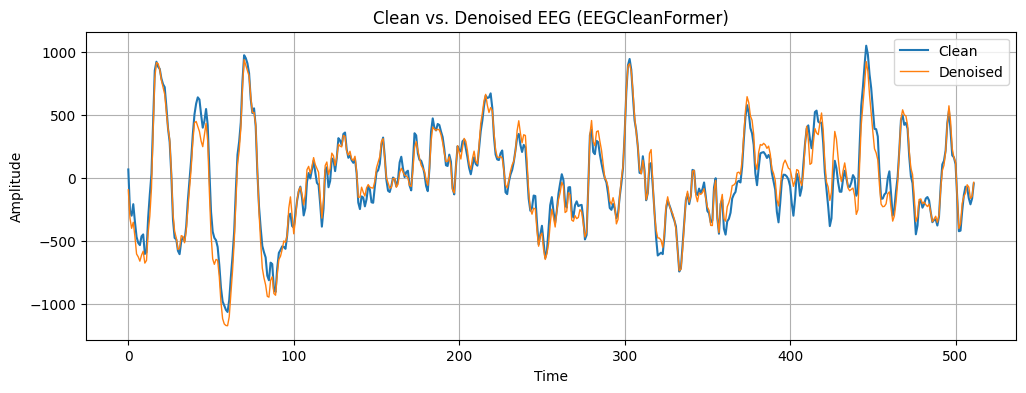

In [20]:
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.stats import pearsonr

# ⚙️ Evaluation Functions
def rrmse(pred, true):
    return np.sqrt(np.mean((pred - true) ** 2)) / np.sqrt(np.mean(true ** 2))

def rrmse_freq(pred, true):
    pred_fft = np.abs(fft(pred))
    true_fft = np.abs(fft(true))
    return np.sqrt(np.mean((pred_fft - true_fft) ** 2)) / np.sqrt(np.mean(true_fft ** 2))

def correlation(pred, true):
    return pearsonr(pred, true)[0]

# 🔍 Evaluate on test set
model.eval()
rrmse_t_list, rrmse_s_list, cc_list = [], [], []

with torch.no_grad():
    for band in bands:
        test_clean, test_contaminated, snr_labels_test = test_data[band]
        break  # use one band just to get correct shape

    for i in range(len(test_clean)):  # Full test set
        # Create 6-band input
        band_stack = []
        for band in bands:
            test_clean_b, test_contaminated_b, _ = test_data[band]
            band_stack.append(test_contaminated_b[i])
        input_tensor = torch.tensor(np.stack(band_stack, axis=0), dtype=torch.float32).unsqueeze(0).to(device)

        target = np.stack([test_data[band][0][i] for band in bands], axis=0).sum(axis=0)  # Sum of clean bands
        denoised = model(input_tensor).cpu().numpy().flatten()

        # Compute metrics
        rrmse_t_list.append(rrmse(denoised, target))
        rrmse_s_list.append(rrmse_freq(denoised, target))
        cc_list.append(correlation(denoised, target))

# 📊 Print averages
print(f"✅ Avg RRMSE-t: {np.mean(rrmse_t_list):.4f}")
print(f"✅ Avg RRMSE-s: {np.mean(rrmse_s_list):.4f}")
print(f"✅ Avg CC     : {np.mean(cc_list):.4f}")

# 📈 Plot example result
plt.figure(figsize=(12, 4))
plt.plot(target, label="Clean", linewidth=1.5)
plt.plot(denoised, label="Denoised", linewidth=1)
plt.title("Clean vs. Denoised EEG (EEGCleanFormer)")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


In [21]:
snr_levels = np.array([-7, -6, -5, -4, -3, -2, -1, 0, 1, 2])

def compute_ts_metric(rrmse_t, rrmse_s):
    return 10 * np.log10(1 / (rrmse_t * rrmse_s))

model.eval()
results_by_snr = {}

with torch.no_grad():
    for snr in snr_levels:
        rrmse_t_list, rrmse_s_list, cc_list = [], [], []

        # Loop through test set
        for i in range(len(test_data["Delta_band"][2])):
            snr_label = test_data["Delta_band"][2][i]
            if snr_label != snr:
                continue

            # Build 6-band input
            band_input = []
            for band in bands:
                band_input.append(test_data[band][1][i])  # contaminated
            x = torch.tensor(np.stack(band_input), dtype=torch.float32).unsqueeze(0).to(device)

            # Sum of clean bands
            target = np.stack([test_data[band][0][i] for band in bands]).sum(axis=0)
            denoised = model(x).cpu().numpy().flatten()

            # Metrics
            rrmse_t_list.append(rrmse(denoised, target))
            rrmse_s_list.append(rrmse_freq(denoised, target))
            cc_list.append(correlation(denoised, target))

        if rrmse_t_list:  # Avoid divide-by-zero if SNR not found
            avg_rrmse_t = np.mean(rrmse_t_list)
            avg_rrmse_s = np.mean(rrmse_s_list)
            avg_cc = np.mean(cc_list)
            ts_metric = compute_ts_metric(avg_rrmse_t, avg_rrmse_s)

            results_by_snr[snr] = (avg_rrmse_t, avg_rrmse_s, avg_cc, ts_metric)

            print(f"✅ SNR {snr}: RRMSE-T = {avg_rrmse_t:.4f}, RRMSE-S = {avg_rrmse_s:.4f}, CC = {avg_cc:.4f}, T&S Metric = {ts_metric:.4f} dB")
        else:
            print(f"⚠️ No test samples for SNR {snr}")


✅ SNR -7: RRMSE-T = 0.3091, RRMSE-S = 0.2153, CC = 0.9526, T&S Metric = 11.7674 dB
✅ SNR -6: RRMSE-T = 0.2507, RRMSE-S = 0.1823, CC = 0.9703, T&S Metric = 13.4003 dB
✅ SNR -5: RRMSE-T = 0.2214, RRMSE-S = 0.1656, CC = 0.9779, T&S Metric = 14.3575 dB
✅ SNR -4: RRMSE-T = 0.1959, RRMSE-S = 0.1498, CC = 0.9834, T&S Metric = 15.3248 dB
✅ SNR -3: RRMSE-T = 0.1776, RRMSE-S = 0.1375, CC = 0.9868, T&S Metric = 16.1222 dB
✅ SNR -2: RRMSE-T = 0.1672, RRMSE-S = 0.1311, CC = 0.9886, T&S Metric = 16.5909 dB
✅ SNR -1: RRMSE-T = 0.1602, RRMSE-S = 0.1259, CC = 0.9898, T&S Metric = 16.9537 dB
✅ SNR 0: RRMSE-T = 0.1556, RRMSE-S = 0.1217, CC = 0.9902, T&S Metric = 17.2270 dB
✅ SNR 1: RRMSE-T = 0.1531, RRMSE-S = 0.1193, CC = 0.9905, T&S Metric = 17.3842 dB
✅ SNR 2: RRMSE-T = 0.1604, RRMSE-S = 0.1219, CC = 0.9889, T&S Metric = 17.0899 dB


📊 Found 680 test samples for SNR Level -5


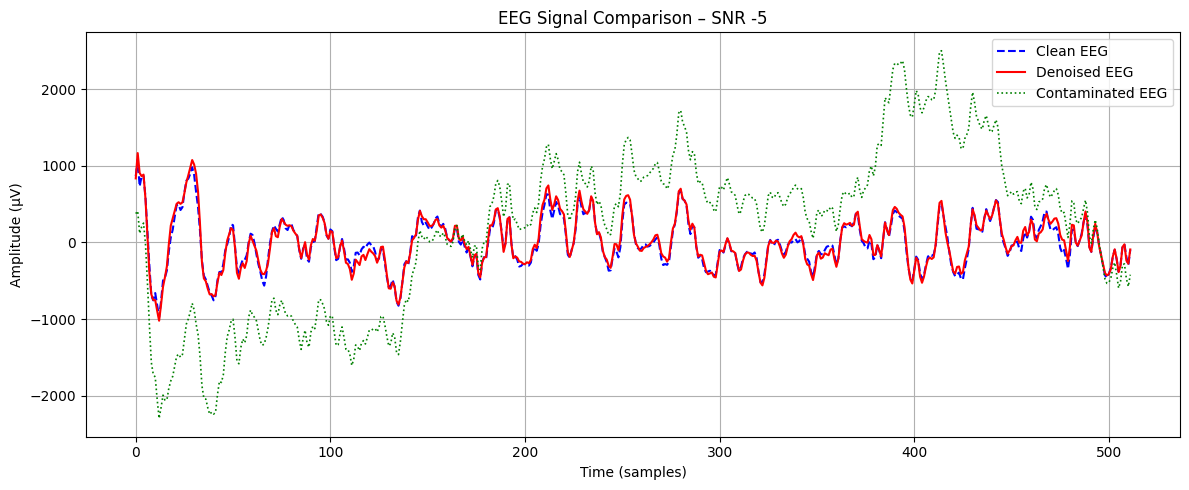

In [22]:
import matplotlib.pyplot as plt

# 📍 Select SNR level
snr_level = -5

# ✅ Extract SNR labels for Delta band (same for all bands)
snr_labels_test_int = np.array(test_data["Delta_band"][2])  # Already converted earlier

# ✅ Find indices of test samples for that SNR
snr_indices = np.where(snr_labels_test_int == snr_level)[0]

if len(snr_indices) == 0:
    print(f"❌ No test samples found for SNR Level {snr_level}.")
else:
    print(f"📊 Found {len(snr_indices)} test samples for SNR Level {snr_level}")
    first_segment_idx = snr_indices[0]

    # ✅ Reconstruct 6-band input and clean + contaminated
    input_stack = np.stack([test_data[band][1][first_segment_idx] for band in bands], axis=0)  # contaminated
    clean_stack = np.stack([test_data[band][0][first_segment_idx] for band in bands], axis=0)

    contaminated_segment = np.sum(input_stack, axis=0)
    clean_segment = np.sum(clean_stack, axis=0)

    # ✅ Run model
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(input_stack, dtype=torch.float32).unsqueeze(0).to(device)
        denoised_segment = model(input_tensor).cpu().numpy().flatten()

    # ✅ Plot
    plt.figure(figsize=(12, 5))
    plt.plot(clean_segment, label="Clean EEG", color="blue", linewidth=1.5, linestyle="dashed")
    plt.plot(denoised_segment, label="Denoised EEG", color="red", linewidth=1.5)
    plt.plot(contaminated_segment, label="Contaminated EEG", color="green", linestyle="dotted", linewidth=1.2)
    
    plt.title(f"EEG Signal Comparison – SNR {snr_level}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude (μV)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [23]:
# ✅ Get denoised EEG plotting points
x_points = list(range(len(clean_segment)))      # X-axis: time/sample index
y_points = clean_segment.tolist()               # Y-axis: denoised EEG values

# ✅ Print the plotting points
print("clean EEG Plotting Points:")
for x, y in zip(x_points, y_points):
    print(f"({x}, {y})")

clean EEG Plotting Points:
(0, 866.0310373030727)
(1, 1079.4841579090378)
(2, 731.6408847576887)
(3, 862.6738819256368)
(4, 866.7140225575605)
(5, 588.8503739903863)
(6, 136.6614304195263)
(7, -298.3566321539266)
(8, -691.6086363740101)
(9, -754.7785125773847)
(10, -658.8089875199304)
(11, -812.5435133345279)
(12, -974.6164566781945)
(13, -764.3228531433821)
(14, -497.6382606196129)
(15, -456.6919091011161)
(16, -364.1676340394712)
(17, -113.02512355681023)
(18, 65.3680415281495)
(19, 168.07068058366949)
(20, 334.0554090712285)
(21, 487.07143375009616)
(22, 495.97321510589194)
(23, 423.62994226470613)
(24, 460.77347049474366)
(25, 654.1538435829957)
(26, 806.8607838956693)
(27, 831.9862958327811)
(28, 895.39447199593)
(29, 980.781445984068)
(30, 880.4319359781017)
(31, 661.5908380495428)
(32, 461.57995471189315)
(33, 154.79332353294816)
(34, -231.5851121937696)
(35, -433.34746686278055)
(36, -481.13233860392177)
(37, -568.7773214602958)
(38, -649.6075087712896)
(39, -692.3427366303621)

In [24]:
# ✅ Get denoised EEG plotting points
x_points = list(range(len(denoised_segment)))      # X-axis: time/sample index
y_points = denoised_segment.tolist()               # Y-axis: denoised EEG values

# ✅ Print the plotting points
print("Denoised EEG Plotting Points:")
for x, y in zip(x_points, y_points):
    print(f"({x}, {y})")

Denoised EEG Plotting Points:
(0, 835.6690673828125)
(1, 1166.003662109375)
(2, 906.4432373046875)
(3, 864.977294921875)
(4, 885.0882568359375)
(5, 568.269775390625)
(6, 84.53174591064453)
(7, -392.34735107421875)
(8, -676.2478637695312)
(9, -749.447509765625)
(10, -752.1783447265625)
(11, -890.0037841796875)
(12, -1019.6953735351562)
(13, -811.13037109375)
(14, -577.91357421875)
(15, -453.1481018066406)
(16, -310.51416015625)
(17, -22.105422973632812)
(18, 220.20343017578125)
(19, 316.75177001953125)
(20, 418.29925537109375)
(21, 504.29833984375)
(22, 525.1837158203125)
(23, 503.6004333496094)
(24, 523.616455078125)
(25, 644.3072509765625)
(26, 783.941162109375)
(27, 876.0108032226562)
(28, 974.2274780273438)
(29, 1075.1395263671875)
(30, 1016.3944091796875)
(31, 896.864013671875)
(32, 662.5728759765625)
(33, 245.6043701171875)
(34, -254.3212127685547)
(35, -468.4541015625)
(36, -506.1083984375)
(37, -602.5271606445312)
(38, -677.0545654296875)
(39, -673.2039794921875)
(40, -703.23773